In [1]:
import numpy as np
import pickle
import torch
import time
import scipy
from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.model_selection import train_test_split
import autosklearn.regression
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
plt.matplotlib.style.use("https://gist.githubusercontent.com/JonnyCBB/c464d302fefce4722fe6cf5f461114ea/raw/64a78942d3f7b4b5054902f2cee84213eaff872f/matplotlibrc")
cool_colors = ['#00BEFF', '#D4CA3A', '#FF6DAE', '#67E1B5', '#EBACFA', '#9E9E9E', '#F1988E', '#5DB15A', '#E28544', '#52B8AA']
cool_colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

plt.rcParams.update({'font.size': 14})

The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


load data from `prepare_Xy.ipynb`

In [2]:
X = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['X']
print("shape of X:", np.shape(X))

y = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['y']
print("shape of y:", np.shape(y))

nb_COFs = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['nb_COFs']
print("# COFs:", nb_COFs)

# feature names
features = pickle.load(open('inputs_and_outputs.pkl', 'rb'))['features']

shape of X: (69839, 12)
shape of y: (69839,)
# COFs: 69839


downsample data (must do b/c memory limitations)

In [3]:
nb_random_sample = 5000
ids_selected = np.random.choice(range(nb_COFs), replace=False, size=nb_random_sample)

X = X[ids_selected, :]
y = y[ids_selected]

nb_COFs = nb_random_sample

test/train split

In [4]:
ids_train, ids_test = train_test_split(np.arange(nb_COFs), train_size=0.8)
print("# training: ", len(ids_train))
print("# test: ", len(ids_test))

X_train = X[ids_train, :]
y_train = y[ids_train]

X_test  = X[ids_test, :]
y_test  = y[ids_test]

# training:  4000
# test:  1000


In [9]:
# train on training data
kernel = Matern(nu=2.5, length_scale=0.25)
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gpr.fit(X_train, y_train)

# get predictions on test data
y_pred = gpr.predict(X_test)

# compute RMSE, R2 on test data
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

/home/cokes/.local/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [10]:
# permutation importance
feature_importances = permutation_importance(gpr, X_test, y_test)

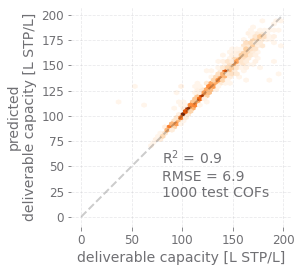

In [14]:
# compute max DC
max_dc = np.max([np.max(y_pred), np.max(y_test)])

# parity plot
plt.figure()
plt.xlabel("deliverable capacity [L STP/L]")
plt.ylabel("predicted\ndeliverable capacity [L STP/L]")
plt.plot([0, max_dc], [0, max_dc], color="k", linestyle="--", alpha=0.2)
plt.hexbin(y_test, y_pred, cmap="Oranges", gridsize=35, mincnt=1)
plt.text(80, 20, "R$^2$ = {:0.1f}\nRMSE = {:0.1f}\n{:d} test COFs".format(r2, rmse, np.size(y_test)))
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig("gp_parity_plot.pdf", format="pdf")
plt.show()

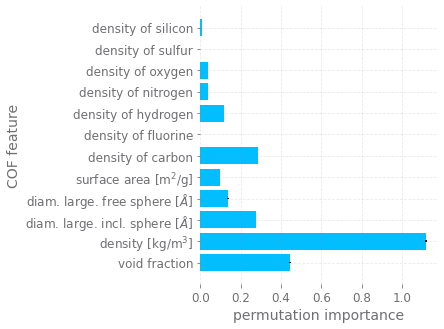

In [13]:
feature_to_label = {feature: feature for feature in features}
feature_to_label[' void fraction [widom]'] = 'void fraction'
feature_to_label[' density [kg/m^3]'] = 'density [kg/m$^3$]'
feature_to_label[' largest included sphere diameter [A]'] = 'diam. large. incl. sphere [$\AA$]'
feature_to_label[' largest free sphere diameter [A]'] = 'diam. large. free sphere [$\AA$]'
feature_to_label[' surface area [m^2/g]'] = 'surface area [m$^2$/g]'

plt.figure(figsize=(6.4, 4.8))
plt.barh([feature_to_label[feature] for feature in features], feature_importances.importances_mean, yerr=feature_importances.importances_std)
# plt.xticks(rotation=90)
plt.xlabel("permutation importance")
plt.ylabel("COF feature")
plt.tight_layout()
plt.savefig("permutation_feature_importance.pdf", format="pdf")